In [25]:
import os
import sys

# Move up to the correct project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Updated Python path:", sys.path)  # Debugging check


Updated Python path: ['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env', '', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\D

In [80]:
!jupyter nbconvert --to script "DQN_Backtest.ipynb"

[NbConvertApp] Converting notebook DQN_Backtest.ipynb to script
[NbConvertApp] Writing 7855 bytes to DQN_Backtest.py


In [78]:
from stable_baselines3 import DQN
import torch
import random
from Environment.environment_withPortfolio import TradingEnv_withPortfolio
from Environment.environment_withoutPortfolio import TradingEnv_withoutPortfolio
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt

MODEL_NAME = 'DQN_final_verglich'

#TradingEnv = TradingEnv_withPortfolio
TradingEnv = TradingEnv_withoutPortfolio

#def run_dqn_backtest_v1():
#def run_dqn_backtest_v2():
#def run_dqn_backtest_v3():
#def run_dqn_backtest_v4():
def run_dqn_backtest_v5():

    
    # === Setup ===
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # === Pfade dynamisch bestimmen ===
    try:
        BASE_DIR = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        BASE_DIR = os.getcwd()

    test_data_path = os.path.join(BASE_DIR, '..', '..', 'Transform_data', 'stand_data', '2025-2024_stand_data.csv')
    scaler_path = os.path.join(BASE_DIR, '..', '..', 'Transform_data', 'scaler.pkl')
    model_path = os.path.join(BASE_DIR, '..', '..', 'Agents', 'DQN', MODEL_NAME)

    # === Daten laden ===
    test_data = pd.read_csv(test_data_path)

    if 'date' in test_data.columns:
        test_data['date'] = pd.to_datetime(test_data['date'], errors='coerce')
        test_data.set_index('date', inplace=True)
    elif 'datetime' in test_data.columns:
        test_data['datetime'] = pd.to_datetime(test_data['datetime'], errors='coerce')  
        test_data.set_index('datetime', inplace=True)
    else:
        raise ValueError("Keine gültige Zeitspalte ('date' oder 'datetime') in test_data gefunden.")

    test_data.dropna(inplace=True)


    # Speichere den Index separat
    full_index = test_data.index

    # === Environment vorbereiten ===
    test_env = TradingEnv(
        data=test_data,
        initial_cash=1,
        window_size=168,
        scaler_path=scaler_path,
        default_seed=SEED
    )

    # === Modell laden ===
    model = DQN.load(model_path)

    # === Episode ausführen ===
    reset_result = test_env.reset(seed=SEED)
    obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    done = False
    action_list = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        step_result = test_env.step(action)
        obs = step_result[0] if isinstance(step_result, tuple) else step_result
        done = step_result[2] if isinstance(step_result, tuple) and len(step_result) >= 3 else False
        action_list.append(action)

    # === Portfolio mit Zeitindex erstellen ===
    portfolio_values = test_env.portfolio_value_history
    portfolio_index = full_index[-len(portfolio_values):]
    portfolio_series = pd.Series(portfolio_values, index=portfolio_index)

    # === Action-Verteilung plotten ===
    action_counts = Counter(action_list)
    actions = list(range(max(action_list) + 1))
    counts = [action_counts.get(a, 0) for a in actions]

    plt.figure(figsize=(8, 5))
    plt.bar(actions, counts, tick_label=actions)
    plt.xlabel("Action")
    plt.ylabel("Frequency")
    plt.title("DQN Agent Action Distribution")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    test_env.render(mode='human')
    return {
        "portfolio": portfolio_series,
        "actions": action_list
    }




Seed in the environment: 42
Seed in the environment: 42


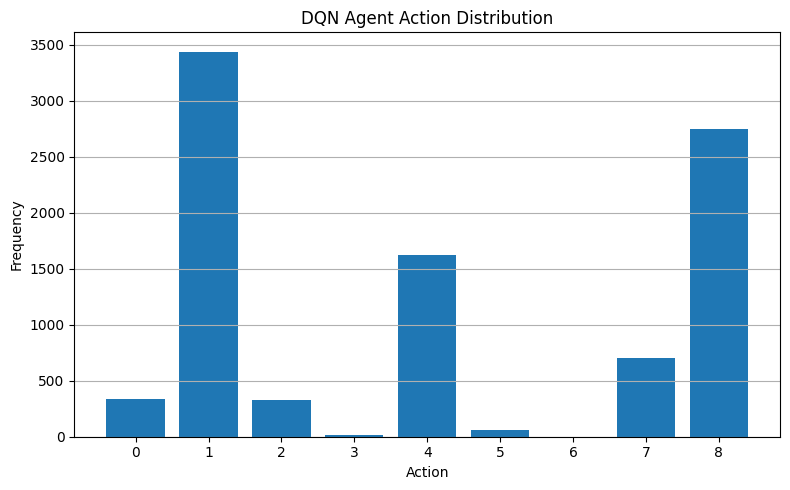

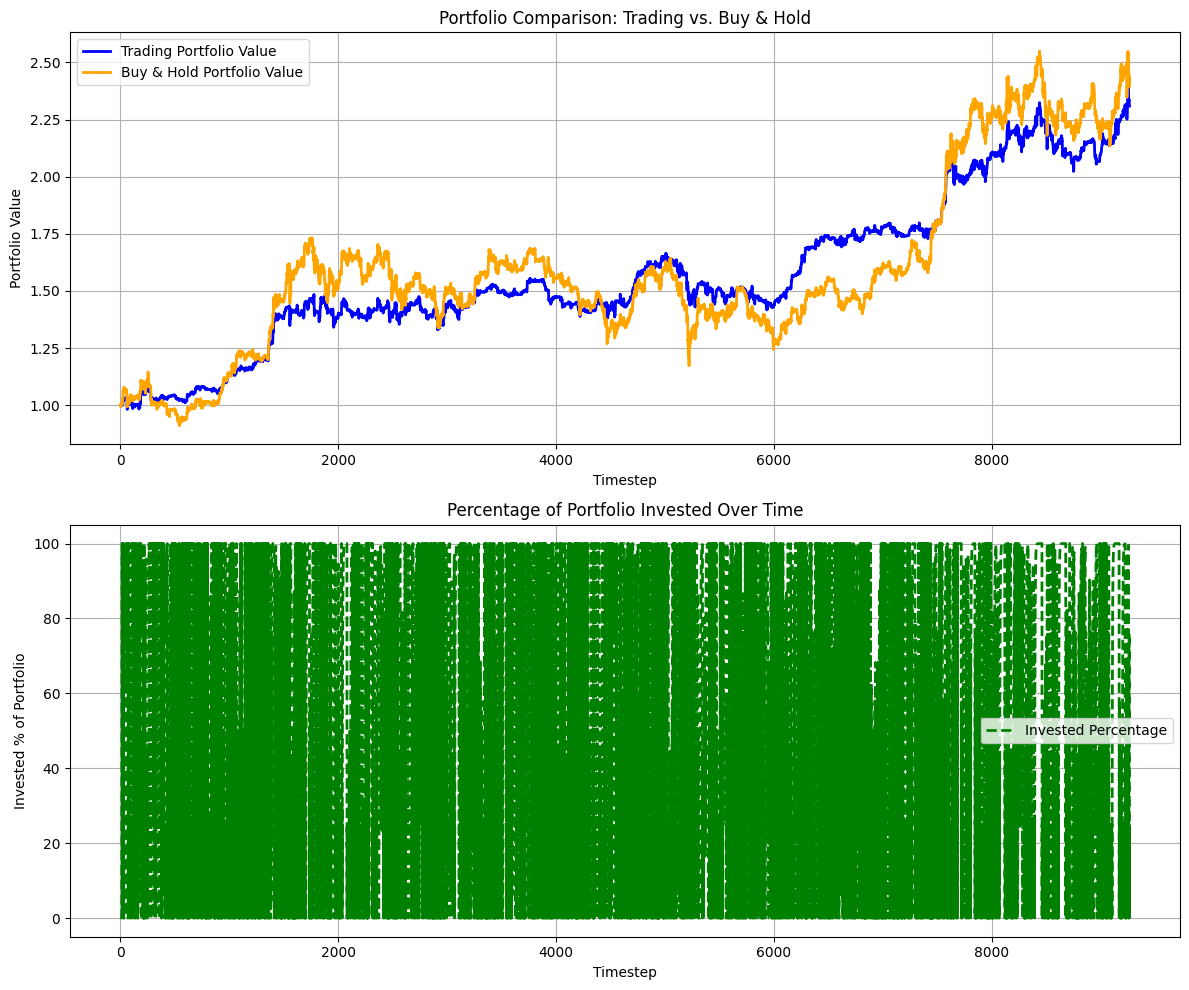

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


In [79]:
dqn_result = run_dqn_backtest_v5()
print(dqn_result["portfolio"].index[:5])


In [ ]:
import numpy as np

def compute_sharpe_ratio(portfolio_values, risk_free_rate=0.0, periods_per_year=8760):
    """
    Compute the Sharpe Ratio using the portfolio returns.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - risk_free_rate: Annual risk-free rate (default: 0).
    - periods_per_year: Number of periods in one year (default: 8760 for hourly data).
    
    Returns:
    - Sharpe ratio (annualized).
    """
    portfolio_values = np.array(portfolio_values)
    # Calculate period-to-period returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    # Calculate excess returns over the period risk-free rate
    excess_returns = returns - risk_free_rate / periods_per_year
    # Annualize the Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(periods_per_year)
    return sharpe_ratio

def compute_max_drawdown(portfolio_values):
    """
    Compute the Maximum Drawdown from the portfolio value history.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    
    Returns:
    - Maximum drawdown as a negative number (e.g., -0.2 means a 20% drawdown).
    """
    portfolio_values = np.array(portfolio_values)
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = np.min(drawdowns)
    return max_drawdown

def compute_annualized_return(portfolio_values, periods_per_year=8760):
    """
    Compute the annualized return (CAGR) based on the portfolio value history.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - periods_per_year: Number of periods in one year.
    
    Returns:
    - Annualized return as a decimal (e.g., 0.12 for 12% per year).
    """
    portfolio_values = np.array(portfolio_values)
    total_periods = len(portfolio_values)
    total_return = portfolio_values[-1] / portfolio_values[0]
    annualized_return = total_return**(periods_per_year / total_periods) - 1
    return annualized_return

def compute_win_loss_rate(portfolio_values):
    """
    Compute the win-loss rate based on the period-to-period returns.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    
    Returns:
    - A tuple (win_rate, loss_rate) where each value is between 0 and 1.
    """
    portfolio_values = np.array(portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    wins = np.sum(returns > 0)
    losses = np.sum(returns <= 0)
    win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0
    loss_rate = 1 - win_rate
    return win_rate, loss_rate

def compute_backtest_metrics(portfolio_values, risk_free_rate=0.0, periods_per_year=8760):
    portfolio = pd.Series(portfolio_values)
    returns = portfolio.pct_change().dropna()

    final_portfolio_value = portfolio.iloc[-1]
    profit = final_portfolio_value - portfolio.iloc[0]

    annualized_return = (final_portfolio_value / portfolio.iloc[0]) ** (periods_per_year / len(portfolio)) - 1
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if returns.std() != 0 else np.nan
    max_drawdown = (portfolio / portfolio.cummax() - 1).min()

    win_rate = (returns > 0).mean()
    loss_rate = (returns < 0).mean()

    return {
        "final_portfolio_value": final_portfolio_value,
        "profit": profit,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown,
        "win_rate": win_rate,
        "loss_rate": loss_rate
    }

result = run_dqn_backtest_v3()
portfolio = result["portfolio"]
metrics = compute_backtest_metrics(portfolio)

# Anzeigen
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



Backtesting Metrics:
final_portfolio_value: 12079.7689
profit: 2079.7689
annualized_return: 0.1956
sharpe_ratio: 0.6545
max_drawdown: -0.4423
win_rate: 0.3195
loss_rate: 0.3087
